In [1]:
import sys
from pathlib import Path

import numpy as np
from astropy import table, nddata
from astropy.io import fits
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec, colors
import cmocean
import betterplotlib as bpl

bpl.set_style()

# need to add the correct path to import utils
legus_home_dir = Path(".").resolve().parent
sys.path.append(str(legus_home_dir / "pipeline"))
import utils
import fit_utils

Other parameters

In [2]:
oversampling_factor = 2
psf_size = 15
snapshot_size = 30
snapshot_size_oversampled = snapshot_size * oversampling_factor

# Choose the cluster here

In [51]:
galaxy = "ngc628-c"
cluster_id = 135
run_name = "radialweighting3pix_abs_bgscale1e3_thetascale1e2_noaprior_noqprior_multiplestarts"

## Then we can load the data

In [52]:
data_dir = legus_home_dir / "data" / galaxy
image_data, _, _ = utils.get_drc_image(data_dir)

error_data = fits.open(data_dir / "size" / "sigma_electrons.fits")["PRIMARY"].data
mask_data = fits.open(data_dir / "size" / "mask_image.fits")["PRIMARY"].data

psf_name = f"psf_my_stars_{psf_size}_pixels_{oversampling_factor}x_oversampled.fits"
psf = fits.open(data_dir / "size" / psf_name)["PRIMARY"].data
psf_cen = int((psf.shape[1] - 1.0) / 2.0)

cat_name = (
    f"cluster_fits_{run_name}_{snapshot_size}_pixels_psf_"
    f"my_stars_{psf_size}_pixels_{oversampling_factor}x_oversampled.h5"
)
cat_path = data_dir / "size" / cat_name
cat = table.Table.read(str(cat_path), format="hdf5")
# then find the correct row
for row in cat:
    if row["ID"] == cluster_id:
        break

# create the snapshot. We use ceiling to get the integer pixel values as python
# indexing does not include the final value. So when we calcualte the offset, it
# naturally gets biased low. Moving the center up fixes that in the easiest way.
x_cen = int(np.ceil(row["x_fitted_best"]))
y_cen = int(np.ceil(row["y_fitted_best"]))

# Get the snapshot, based on the size desired.
# Since we took the ceil of the center, go more in the negative direction (i.e.
# use ceil to get the minimum values). This only matters if the snapshot size is odd
x_min = x_cen - int(np.ceil(snapshot_size / 2.0))
x_max = x_cen + int(np.floor(snapshot_size / 2.0))
y_min = y_cen - int(np.ceil(snapshot_size / 2.0))
y_max = y_cen + int(np.floor(snapshot_size / 2.0))

data_snapshot = image_data[y_min:y_max, x_min:x_max].copy()
error_snapshot = error_data[y_min:y_max, x_min:x_max].copy()
mask_snapshot = mask_data[y_min:y_max, x_min:x_max].copy()

snapshot_x_cen = row["x_fitted_best"] - x_min
snapshot_y_cen = row["y_fitted_best"] - y_min
# Use the same mask region as was used in the actual fitting procedure
mask_snapshot = fit_utils.handle_mask(mask_snapshot, row["ID"])

## Convenience functions to be used later

In [53]:
best_fit_params = [
    np.log10(row["central_surface_brightness_best"]),
    fit_utils.image_to_oversampled(snapshot_x_cen, oversampling_factor),
    fit_utils.image_to_oversampled(snapshot_y_cen, oversampling_factor),
    row["scale_radius_pixels_best"],
    row["axis_ratio_best"],
    row["position_angle_best"],
    row["power_law_slope_best"],
    row["local_background_best"],
]
# estimated_bg = row['estimated_local_background']
# estimated_bg_scatter = row["estimated_local_background_scatter"]

fit_models = fit_utils.create_model_image(*best_fit_params, psf, snapshot_size_oversampled, oversampling_factor)
fit_model_image, fit_model_psf_image, fit_model_psf_bin_image = fit_models

fit_sigma_snapshot = (data_snapshot - fit_model_psf_bin_image) / error_snapshot

In [54]:
def create_radial_profile(model_psf_bin_image, cluster_snapshot, mask, x_c, y_c):
    """
    Make a radial profile of cluster and model pixel values

    :param model_psf_bin_image: the model image on the same pixel scale as the data
    :param cluster_snapshot: the data snapshot
    :param mask: the mask indicating which pixel values to not use
    :param x_c: X coordinate of the center in snapshot coordinates
    :param y_c: Y coordinate of the center in snapshot coordinates
    :return: Three numpy arrays: The radii of all pixel values, in sorted order, the
             model values at these radii, then the data values at these radii
    """
    # When fitting I treated the center of the pixels as the integer location, so do
    # that here too
    radii, model_ys, data_ys = [], [], []
    for x in range(model_psf_bin_image.shape[1]):
        for y in range(model_psf_bin_image.shape[0]):
            if mask[y][x] > 0:
                radii.append(fit_utils.distance(x, y, x_c, y_c))
                model_ys.append(model_psf_bin_image[y, x])
                data_ys.append(cluster_snapshot[y, x])

    # sort everything in order of radii
    idxs = np.argsort(radii)
    return np.array(radii)[idxs], np.array(model_ys)[idxs], np.array(data_ys)[idxs]

def bin_profile(radii, pixel_values, bin_size):
    """
    Take an existing profile and bin it azimuthally

    :param radii: Radii values corresponding to the pixel values
    :param pixel_values: Values at the radii passed in
    :param bin_size: How big the bins should be, in pixels
    :return: Binned radii and pixel values
    """
    binned_radii, binned_ys = [], []
    for r_min in np.arange(0, int(np.ceil(max(radii))), bin_size):
        r_max = r_min + bin_size
        idx_above = np.where(r_min < radii)
        idx_below = np.where(r_max > radii)
        idx_good = np.intersect1d(idx_above, idx_below)

        if len(idx_good) > 0:
            binned_radii.append(r_min + 0.5 * bin_size)
            binned_ys.append(np.mean(pixel_values[idx_good]))

    return np.array(binned_radii), np.array(binned_ys)


def rms(sigmas, x_c, y_c, max_radius):
    """
    Calculate the RMS of the pixels within some radius

    :param sigmas: Deviations of the pixels from the fit
    :param x_c: X coordinate of the center, in coordinates of the sigmas snapshot
    :param y_c: Y coordinate of the center, in coordinates of the sigmas snapshot
    :param max_radius: Maximum radius to include in the calculation
    :return: sqrt(mean(sigmas**2)) where r < max_radius
    """
    good_sigmas = []
    for x in range(sigmas.shape[1]):
        for y in range(sigmas.shape[0]):
            if fit_utils.distance(x, y, x_c, y_c) < max_radius:
                good_sigmas.append(sigmas[y, x])

    return np.sqrt(np.mean(np.array(good_sigmas) ** 2))


def mad_of_cumulative(radii, model_cumulative, data_cumulative, max_radius):
    """
    Calculate the median relative absolute deviation of the cumulative distribution
    within some radius. This is median(abs(model - data) / data) where r < r_max

    :param radii: List of radii
    :param model_cumulative: Cumulative pixel values for the model as a function of r
    :param data_cumulative: Cumulative pixel values for the data as a function of r
    :param max_radius: Maximum radius to include in the calculation
    :return: median(abs(model - data) / data) where r < r_max
    """
    mask_good = radii < max_radius
    diffs = np.abs(model_cumulative - data_cumulative) / data_cumulative
    return np.median(diffs[mask_good])

In [55]:
def plot_model_set(
    cluster_snapshot,
    uncertainty_snapshot,
    mask,
    params1,
    params2,
#     estimated_bg,
#     bg_scatter,
    radial_weighting
):
    # create copies of the image
    cluster_snapshot = cluster_snapshot.copy()
    uncertainty_snapshot = uncertainty_snapshot.copy()
    # do the radial weighting. Need to get the data coordinates of the center
    weight_snapshot = fit_utils.radial_weighting(
        uncertainty_snapshot,
        fit_utils.oversampled_to_image(params1[1], oversampling_factor),
        fit_utils.oversampled_to_image(params1[2], oversampling_factor),
        style=radial_weighting,
    )
    
    mask = mask.copy()
    
    model_image1, model_psf_image1, model_psf_bin_image1 = fit_utils.create_model_image(
        *params1, psf, snapshot_size_oversampled, oversampling_factor
    )
    model_image2, model_psf_image2, model_psf_bin_image2 = fit_utils.create_model_image(
        *params2, psf, snapshot_size_oversampled, oversampling_factor
    )
    
    print(np.min(model_psf_bin_image2), np.min(model_psf_bin_image2))

    diff_image1 = cluster_snapshot - model_psf_bin_image1
    diff_image2 = cluster_snapshot - model_psf_bin_image2
    sigma_image1 = weight_snapshot * diff_image1 / uncertainty_snapshot
    sigma_image2 = weight_snapshot * diff_image2 / uncertainty_snapshot
    
    # have zeros in the sigma image where the mask has zeros, but leave it unmodified
    # otherwise
    sigma_image1 *= np.minimum(mask, 1.0)
    sigma_image2 *= np.minimum(mask, 1.0)

    # set up the normalizations and colormaps
    # Use the data image to get the normalization that will be used in all plots. Base
    # it on the data so that it is the same in all bootstrap iterations
    vmax = 2 * np.max(cluster_snapshot)
    linthresh = 3 * np.min(uncertainty_snapshot)
    data_norm = colors.SymLogNorm(
        vmin=-vmax, vmax=vmax, linthresh=linthresh, base=10
    )
    sigma_norm = colors.Normalize(vmin=-1, vmax=1)
    u_norm = colors.Normalize(0, vmax=1.2 * np.max(uncertainty_snapshot))
    m_norm = colors.Normalize(0, vmax=np.max(mask))
    w_norm = colors.LogNorm(0.1, np.max(weight_snapshot))

    data_cmap = bpl.cm.lisbon
    sigma_cmap = cmocean.cm.tarn  # "bwr_r" also works
    u_cmap = cmocean.cm.deep_r
    m_cmap = cmocean.cm.gray_r
    w_cmap = cmocean.cm.dense_r

    # create the figure and add all the subplots
    fig = plt.figure(figsize=[25, 15])
    gs = gridspec.GridSpec(
        nrows=6,
        ncols=5,
        width_ratios=[10, 10, 10, 1, 15],  # have a dummy spacer column
        wspace=0.1,
        hspace=0.7,
        left=0.01,
        right=0.98,
        bottom=0.06,
        top=0.94,
    )
    ax_d = fig.add_subplot(gs[2:4, 0], projection="bpl")  # data
    ax_u = fig.add_subplot(gs[4:, 0], projection="bpl")  # uncertainty
    ax_w = fig.add_subplot(gs[0:2:, 0], projection="bpl")  # weights
    
    ax_r1 = fig.add_subplot(gs[0:2, 1], projection="bpl")  # raw model
    ax_f1 = fig.add_subplot(gs[2:4, 1], projection="bpl")  # full model (f for fit)
    ax_s1 = fig.add_subplot(gs[4:, 1], projection="bpl")  # sigma difference
    
    ax_r2 = fig.add_subplot(gs[0:2, 2], projection="bpl")  # raw model
    ax_f2 = fig.add_subplot(gs[2:4, 2], projection="bpl")  # full model (f for fit)
    ax_s2 = fig.add_subplot(gs[4:, 2], projection="bpl")  # sigma difference
    
    
    ax_pd = fig.add_subplot(
        gs[0:3, 4], projection="bpl"
    )  # radial profile differential
    ax_pc = fig.add_subplot(
        gs[3:, 4], projection="bpl"
    )  # radial profile cumulative

    # show the images in their respective panels
    common_data = {"norm": data_norm, "cmap": data_cmap}
    d_im = ax_d.imshow(cluster_snapshot, **common_data, origin="lower")
    u_im = ax_u.imshow(uncertainty_snapshot, norm=u_norm, cmap=u_cmap, origin="lower")
    w_im = ax_w.imshow(weight_snapshot, norm=w_norm, cmap=w_cmap, origin="lower")
    
    r_im1 = ax_r1.imshow(model_image1, **common_data, origin="lower")
    f_im1 = ax_f1.imshow(model_psf_bin_image1, **common_data, origin="lower")
    s_im1 = ax_s1.imshow(sigma_image1, norm=sigma_norm, cmap=sigma_cmap, origin="lower")
    r_im2 = ax_r2.imshow(model_image2, **common_data, origin="lower")
    f_im2 = ax_f2.imshow(model_psf_bin_image2, **common_data, origin="lower")
    s_im2 = ax_s2.imshow(sigma_image2, norm=sigma_norm, cmap=sigma_cmap, origin="lower")

    fig.colorbar(d_im, ax=ax_d)
    fig.colorbar(u_im, ax=ax_u)
    fig.colorbar(w_im, ax=ax_w)
    fig.colorbar(r_im1, ax=ax_r1)
    fig.colorbar(f_im1, ax=ax_f1)
    fig.colorbar(s_im1, ax=ax_s1)
    fig.colorbar(r_im2, ax=ax_r2)
    fig.colorbar(f_im2, ax=ax_f2)
    fig.colorbar(s_im2, ax=ax_s2)

    ax_d.set_title("Data")
    ax_u.set_title("Uncertainty")
    ax_w.set_title("Weight")
    
    ax_r1.set_title("Best Fit\nRaw Cluster Model")
    ax_f1.set_title("Model Convolved\nwith PSF and Binned")
    ax_s1.set_title("(Data - Model)/Uncertainty")
    
    ax_r2.set_title("Guess\nRaw Cluster Model")
    ax_f2.set_title("Model Convolved\nwith PSF and Binned")
    ax_s2.set_title("(Data - Model)/Uncertainty")

    for ax in [ax_d, ax_u, ax_w, ax_r1, ax_r2, ax_f1, ax_f1, ax_s1, ax_s2]:
        ax.remove_labels("both")
        ax.remove_spines(["all"])

#     # add an X marker to the location of the center
#     # the rest are image coords
#     x_image = fit_utils.oversampled_to_image(params1[1], oversampling_factor)
#     y_image = fit_utils.oversampled_to_image(params1[2], oversampling_factor)
#     for ax in [ax_d, ax_u, ax_s1, ax_s2]:
#         ax.scatter([x_image], [y_image], marker="x", c=bpl.almost_black)
#     # make the marker white in the mask plot
#     ax_m.scatter([x_image], [y_image], marker="x", c="w")

#     # Then make the radial plots. first background subtract
#     cluster_snapshot -= params1[7]
#     model_psf_bin_image1 -= params1[7]
#     model_psf_bin_image2 -= params2[7]

    c_d = bpl.color_cycle[0]
    c_m1 = bpl.color_cycle[1]
    c_m2 = bpl.color_cycle[2]
    # the center is in oversampled coords, fix that
    x_c = fit_utils.oversampled_to_image(params1[1], oversampling_factor)
    y_c = fit_utils.oversampled_to_image(params1[2], oversampling_factor)

    radii, model_ys1, data_ys = create_radial_profile(
        model_psf_bin_image1, cluster_snapshot, mask, x_c, y_c
    )
    radii, model_ys2, data_ys = create_radial_profile(
        model_psf_bin_image2, cluster_snapshot, mask, x_c, y_c
    )

    ax_pd.scatter(radii, data_ys, c=c_d, s=5, alpha=1.0, label="Data")
    ax_pd.scatter(radii, model_ys1, c=c_m1, s=5, alpha=1.0, label="Best Fit")
    ax_pd.scatter(radii, model_ys2, c=c_m2, s=5, alpha=1.0, label="Guess")
    ax_pd.axhline(0, ls=":", c=bpl.almost_black) 

    # then bin this data to make the binned plot
    ax_pd.plot(*bin_profile(radii, data_ys, 1.0), c=c_d, lw=5, label="Binned Data")
    ax_pd.plot(
        *bin_profile(radii, model_ys1, 1.0), c=c_m1, lw=5, label="Binned Best Fit"
    )
    ax_pd.plot(
        *bin_profile(radii, model_ys2, 1.0), c=c_m2, lw=5, label="Binned Guess"
    )

    ax_pd.legend(loc="upper right")
    ax_pd.add_labels(
        "Radius (pixels)", "Pixel Value [$e^{-}$]"
    )
    # set min and max values so it's easier to flip through bootstrapping plots
    y_min = np.min(cluster_snapshot)
    y_max = np.max(cluster_snapshot)
    # give them a bit of padding
    diff = y_max - y_min
    y_min -= 0.1 * diff
    y_max += 0.1 * diff
    ax_pd.set_limits(0, np.ceil(max(radii)), y_min, y_max)

    # then make the cumulative one. The radii are already in order so this is easy
    model_ys_cumulative1 = np.cumsum(model_ys1)
    model_ys_cumulative2 = np.cumsum(model_ys2)
    data_ys_cumulative = np.cumsum(data_ys)

    ax_pc.plot(radii, data_ys_cumulative, c=c_d, label="Data")
    ax_pc.plot(radii, model_ys_cumulative1, c=c_m1, label="Best Fit")
    ax_pc.plot(radii, model_ys_cumulative2, c=c_m2, label="Guess")
    ax_pc.set_limits(0, np.ceil(max(radii)), 0, 1.2 * np.max(data_ys_cumulative))
    ax_pc.legend(loc="upper left")
    ax_pc.add_labels(
        "Radius (pixels)", "Cumulative Pixel Values [$e^{-}$]"
    )

    # the last one just has the list of parameters
    ax_pc.easy_add_text(
        f"log(peak brightness) = {params1[0]:.2f} - {params2[0]:.2f}\n" 
        f"scale radius [pixels] = {params1[3]:.2g} - {params2[3]:.2g}\n"
        f"q (axis ratio) = {params1[4]:.2f} - {params2[4]:.2f}\n"
        f"position angle = {params1[5]:.2f} - {params2[5]:.2f}\n"
        f"$\eta$ (power law slope) = {params1[6]:.2f} - {params2[6]:.2f}\n"
        f"background = {params1[7]:.2f} - {params2[7]:.2f}\n\n"
        f"$\chi^2$ = {np.sum(np.abs(sigma_image1)):,.4f} - {np.sum(np.abs(sigma_image2)):,.4f}\n\n",
#         f"estimated background = {estimated_bg:.2f}$\pm${bg_scatter:.2f}\n",
        "lower right",
        fontsize=15,
    )

# Then plot the guesses

In [58]:
guess_params = (4.544442,   29.928924,   30.091186,    0.606937,    0.747855,    0.981812,    1.378276,   21.705245)

21.801742815702966 21.801742815702966


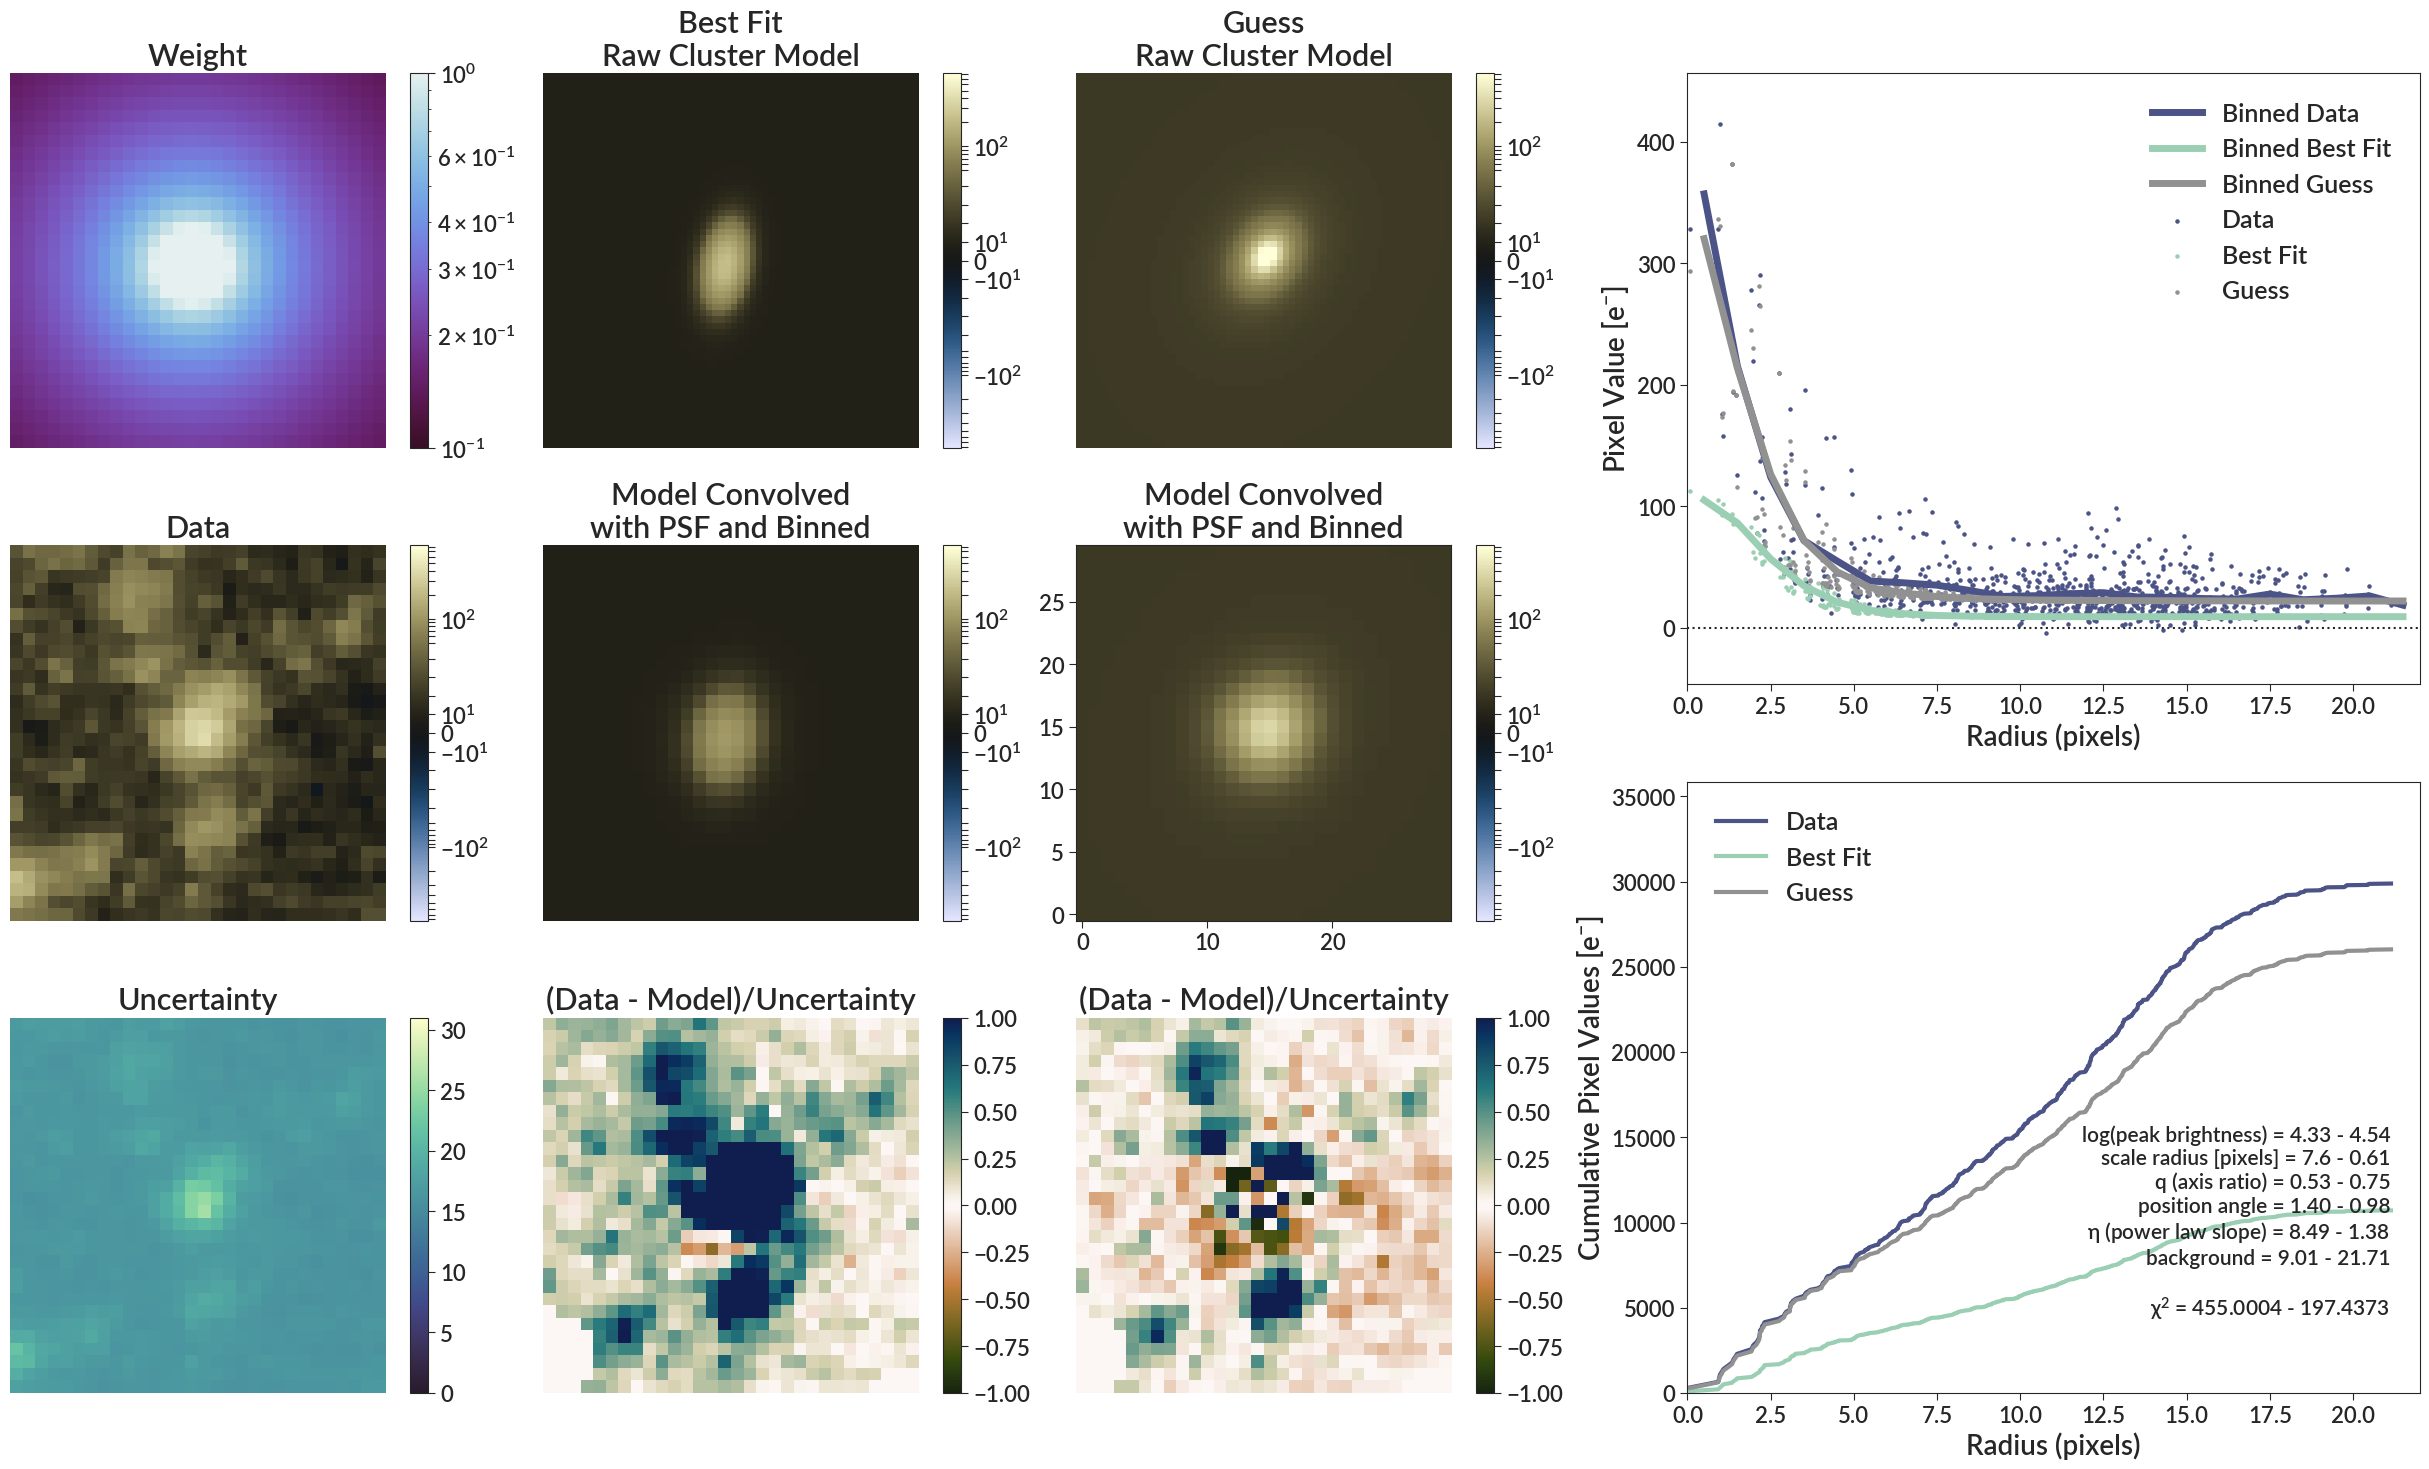

In [59]:
plot_model_set(data_snapshot, error_snapshot, mask_snapshot,
              best_fit_params, guess_params, "annulus")

# compare multiple starts

In [10]:
row["log_likelihood_x0_variations"]

array([-175.97078976, -180.52168801, -175.55032854, -179.34387809,
       -179.73075491, -177.60238868, -154.55836435])

In [11]:
# for idx in range(7):
#     params = [
#         np.log10(row["central_surface_brightness_x0_variations"][idx]),
#         fit_utils.image_to_oversampled(snapshot_x_cen, oversampling_factor),
#         fit_utils.image_to_oversampled(snapshot_y_cen, oversampling_factor),
#         row["scale_radius_pixels_x0_variations"][idx],
#         row["axis_ratio_x0_variations"][idx],
#         row["position_angle_x0_variations"][idx],
#         row["power_law_slope_x0_variations"][idx],
#         row["local_background_x0_variations"][idx],
#     ]
#     plot_model_set(data_snapshot, error_snapshot, mask_snapshot,
#               best_fit_params, params, "annulus")

# simple calculation of chi^2

In [12]:
def calculate_model_chi_sq(
    cluster_snapshot,
    uncertainty_snapshot,
    mask,
    params1,
    radial_weighting
):
    # create copies of the image
    cluster_snapshot = cluster_snapshot.copy()
    uncertainty_snapshot = uncertainty_snapshot.copy()
    # do the radial weighting. Need to get the data coordinates of the center
    weight_snapshot = fit_utils.radial_weighting(
        uncertainty_snapshot,
        fit_utils.oversampled_to_image(params1[1], oversampling_factor),
        fit_utils.oversampled_to_image(params1[2], oversampling_factor),
        style=radial_weighting,
    )
    
    mask = mask.copy()
    
    model_image1, model_psf_image1, model_psf_bin_image1 = fit_utils.create_model_image(
        *params1, psf, snapshot_size_oversampled, oversampling_factor
    )

    diff_image1 = cluster_snapshot - model_psf_bin_image1
    sigma_image1 = weight_snapshot * diff_image1 / uncertainty_snapshot
    
    # have zeros in the sigma image where the mask has zeros, but leave it unmodified
    # otherwise
    sigma_image1 *= np.minimum(mask, 1.0)
    return np.sum(np.abs(sigma_image1))

In [13]:
calculate_model_chi_sq(data_snapshot, error_snapshot, mask_snapshot,
              best_fit_params, "annulus")

724.354455307376

# Fitting fake data

In [14]:
fake_params = [3,
        30,
        30,
        1,  # a
        0.95,  # q
        1.25,  # theta
        1.25,  # eta
        123]

fake_fit_params = [3.284044180175052, 29.998180858673287, 30.00159080347391, 1.1889107184019592, 0.7549555140758357, 1.4637769366870756, 1.9059757449936767, 125.51276056810471]



In [15]:
fake_data = fit_utils.create_model_image(
        *fake_params,
        psf,
        snapshot_size_oversampled,
        oversampling_factor,
    )[-1]

In [16]:
print(calculate_model_chi_sq(fake_data, error_snapshot, mask_snapshot, fake_fit_params, "annulus"))
print("======")
for i in range(7):
    print("--")
    mix = fake_fit_params.copy()
    mix[i] *= 1.0001
    print(calculate_model_chi_sq(fake_data, error_snapshot, mask_snapshot, mix, "annulus"))
    
    mix = fake_fit_params.copy()
    mix[i] /= 1.0001
    print(calculate_model_chi_sq(fake_data, error_snapshot, mask_snapshot, mix, "annulus"))
    
    mix = fake_fit_params.copy()
    mix[i] = fake_params[i]
    print(calculate_model_chi_sq(fake_data, error_snapshot, mask_snapshot, mix, "annulus"))
    

39.86030733770275
--
39.872218059632914
39.84840680861032
32.30169783780181
--
39.85872429185926
39.861890988967446
39.8593472603213
--
39.860939022989285
39.85967836940362
39.85997346989714
--
39.86025515944884
39.86035951277012
39.947493522301556
--
39.86179645484845
39.85881834984651
43.638292604423214
--
39.86029910373226
39.860315564182656
39.8649743775087
--
39.860375814672636
39.86023887782832
39.99120372855332


125.5137526738475 125.5137526738475


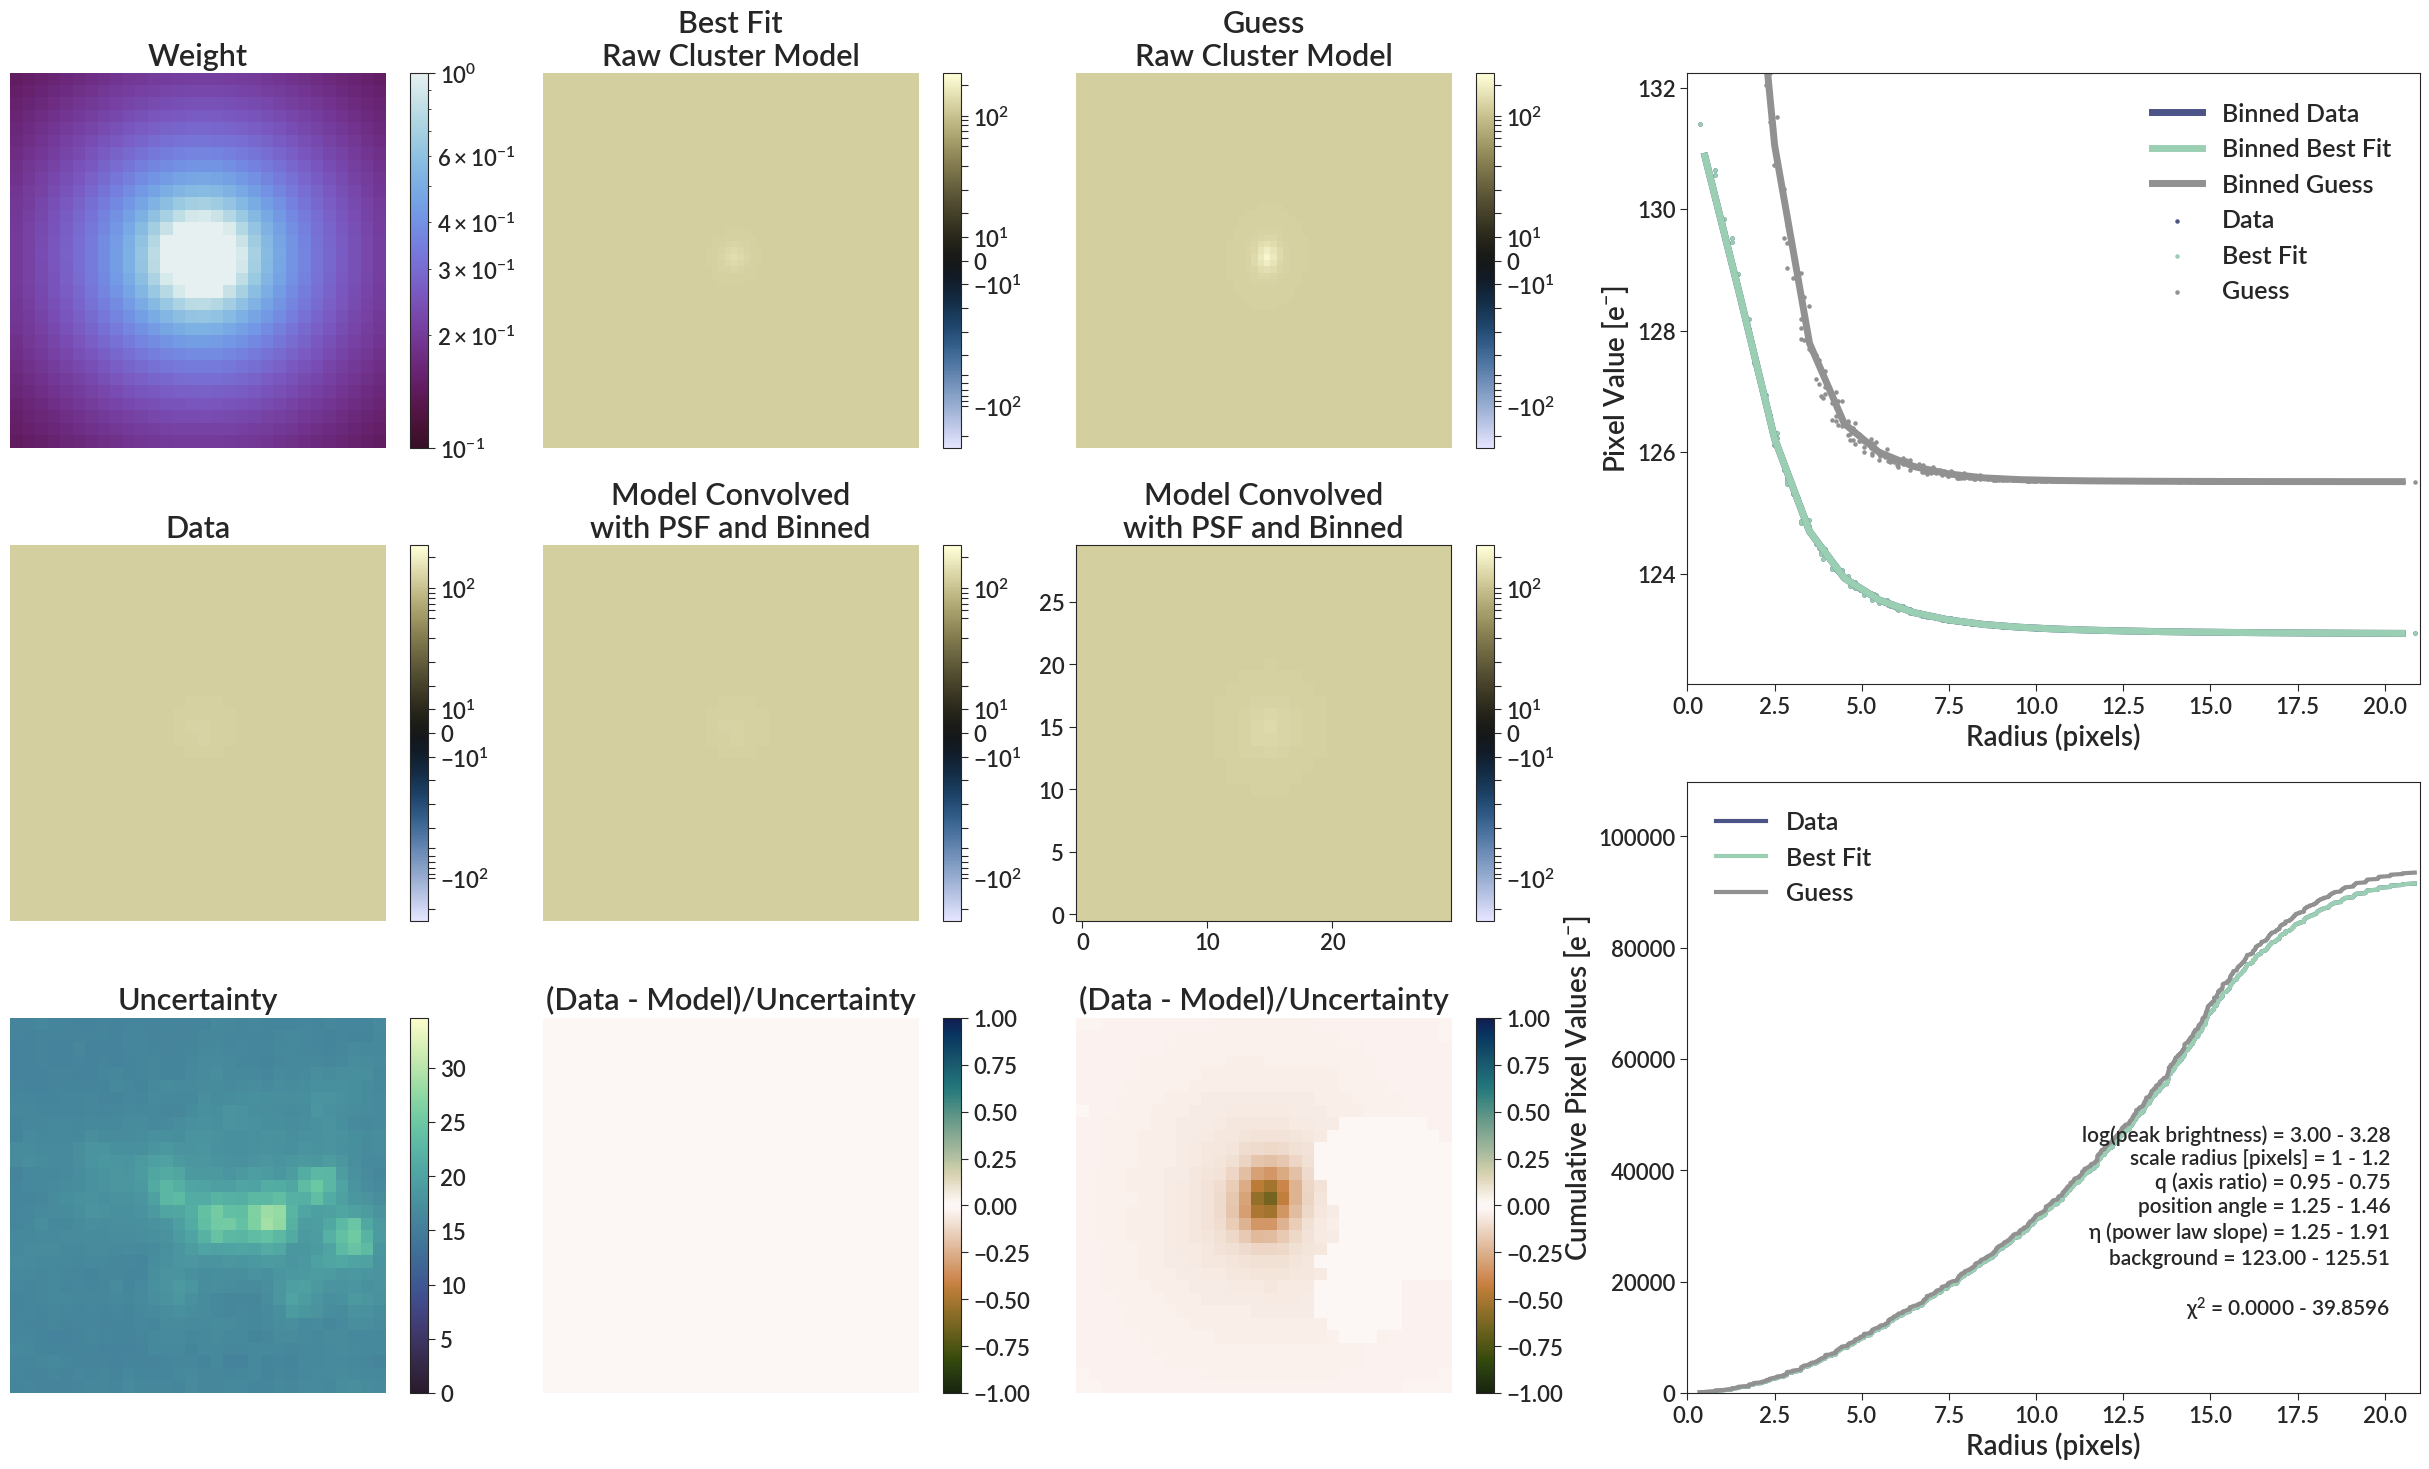

In [17]:
plot_model_set(fake_data, error_snapshot, mask_snapshot,
              fake_params, fake_fit_params, "annulus")
               